# QBUS6830 Tutorial Lab 13: Forecasting 1 day ahead ES and Reg-GARCH models

## Data

#### The file `ao_yf_2009_2021.csv` contains the daily values (open, high, low, close) for the All Ordinaries index on the ASX from January, 2009 to July, 2021.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from scipy.optimize import fmin
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from arch import univariate
import sys

### Q1 (VaR and ES forecasting, h = 1) 

#### Generate 1-step-ahead VaR and ES forecasts for the last 1000 days of AORD returns, using the models: GARCH, GJR, EGARCH, with both Gaussian and Student-t errors; as well as RM and HS-100 . Update parameter estimates every 20 days.

In [2]:
# Download AORD data
name_ao = 'ao_yf_2009_2021.csv'
if not os.path.isfile(name_ao):
    data_ao = yf.download("^AORD", start='2009-01-01', end='2021-10-23')
    data_ao.to_csv(name_ao)

data_ao = pd.read_csv(name_ao, index_col='Date', parse_dates=True, dayfirst=True)
r_ao = 100 * np.log(data_ao['Adj Close']).diff().dropna()
r_ao

Date
2009-01-05   -0.460617
2009-01-06    1.372821
2009-01-07    1.051591
2009-01-08   -2.295330
2009-01-09    1.004918
                ...   
2021-10-18    0.201772
2021-10-19    0.006502
2021-10-20    0.479978
2021-10-21    0.016820
2021-10-22   -0.022001
Name: Adj Close, Length: 3237, dtype: float64

In [3]:
# Last day of in-sample period
last_in = '2017-11-09'
# First day of forecasting period
frst_fc = '2017-11-10'

len(r_ao['2017-11-10':])

# Leave out last 1000 days for forecasting

1000

In [4]:
'''
IGARCH (RiskMetrics) update function
r: vector of returns.
v0: scalar, initial variance.
returns: vector of one-step-ahead forecasts, aligned with r.
'''
def igarch_update(r, v0):
    v = pd.Series(index=r.index, dtype='float64')
    v[0] = v0
    for t in range(1, len(r)):
        v[t] = 0.94 * v[t - 1] + 0.06 * r[t - 1] ** 2
    return v

In [5]:
# For VaR and ES calculations under Gaussian and Standardised-t distributions
def qn(p):
    return stats.norm.ppf(p)

def qt(p, df):
    return stats.t.ppf(p, df) * np.sqrt((df - 2) / df)

def esn(p):
    ninv = stats.norm.ppf(p)
    return -stats.norm.pdf(ninv) / p

def est(p, df):
    tinv = stats.t.ppf(p, df)
    f = lambda x: stats.t.pdf(x, df)
    return -f(tinv) / p * (df + tinv ** 2) / (df - 1) * np.sqrt((df - 2) / df)

def mcn(p, n):
    z = np.random.normal(size=n)
    var = np.quantile(z, p)
    es = np.mean(z[z < var])
    return (var, es)

def mct(p, df, n):
    t = np.random.standard_t(df, size=n)
    z = t * np.sqrt((df - 2) / df)
    var = np.quantile(z, p)
    es = np.mean(z[z < var])
    return (var, es)

def es(r, p):
    var = np.quantile(r, p)
    return np.mean(r[r < var])

def es_to_var_n(p):
    ninv = stats.norm.ppf(p)
    return stats.norm.cdf((-1 / p) * stats.norm.pdf(ninv))

def es_to_var_t(p, df):
    tinv = stats.t.ppf(p, df)
    tpdf = stats.t.pdf(tinv, df)
    temp = (-1 / p) * tpdf * (df + tinv ** 2) / (df - 1)
    return stats.t.cdf(temp, df)

In [6]:
# ES residuals
def es_resid(es, var, s, r):
    xi = r[r < var] - es[r < var]
    return (xi.dropna(), (xi / s).dropna())

def ttest(x, mu):
    n = len(x)
    xbar = np.mean(x)
    s = np.std(x, ddof=1)
    t = (xbar - mu) / (s / np.sqrt(n))
    pval = 2 * stats.t.sf(np.abs(t), df=(n - 1))
    return pval, t

# Unconditional coverage test
def uctest(hit, a):
    n = len(hit)
    p = np.sum(hit) / n
    z = (p - a) / np.sqrt(a * (1 - a) / n)
    pval = 2 * stats.norm.sf(np.abs(z))
    return pval, p

# Independence test
def indtest(hits):
    n = len(hits)

    r5 = hits.values[1:]
    r51 = hits.values[:-1]
    i11 = r5*r51
    i01 = r5*(1-r51)
    i10 = (1-r5)*r51
    i00 = (1-r5)*(1-r51)

    t00 = np.sum(i00)
    t01 = np.sum(i01)
    t10 = np.sum(i10)
    t11 = np.sum(i11)
    p01 = t01/(t00+t01)
    p11 = t11/(t10+t11)
    p1 = (t01+t11)/n

    ll1 = t00 * np.log(1-p01) + (p01>0) * t01 * np.log(p01) + t10 * np.log(1-p11)
    if p11>0:
        ll1=ll1+t11*np.log(p11)
  
    ll0=(t10+t00)*np.log(1-p1)+(t01+t11)*np.log(p1)

    lrind=2*(ll1-ll0)
    pcc=1-stats.chi2.cdf(lrind,1)
    return pcc, lrind

# Dynamic quantile test
def dqtest(y,f,a,lag):
    n = len(y)
    hits = ((y<f)*1)*(1-a)
    hits = (hits)*1+(y>f)*(-a)
    q=2+lag
    
    if np.sum((y<f)*1) > 0:
        ns = n - lag
        xmat = np.column_stack([np.ones((ns,1)), f[lag:n+1]])
        for k in range(1,lag+1):
            lk = lag-k
            xmat = np.column_stack([xmat, hits[lk:n-k]])
    
        hx = np.dot((hits[lag:n+1]), xmat)
        xtx = np.linalg.lstsq(np.matmul(xmat.T, xmat), np.eye(q), rcond = None)[0]
        dq = np.dot(np.dot(hx, xtx), hx.T)
        dq = dq/(a*(1-a))
        pdq = 1 - stats.chi2.cdf(dq,q)
    else:
        pdq = np.nan
        dq = np.nan
    return pdq, dq

# Quantile loss function
def qloss(q,r,p):
    q = np.array(q)
    x1 = r[r > q]
    x2 = r[r < q]
    f1 = q[r > q]
    f2 = q[r < q]
    l = p * np.sum(x1-f1) + (1-p) * np.sum(f2-x2)
    return l

# Joint loss function
def jointloss(es,q,r,p):
    m = len(r)
    q = np.array(q)
    es = np.array(es)
    i1 = (r < q).astype(int)
    aes = es ** (-1) * (p-1)
    ees = (r-q) * (p - i1)
    l =  np.sum(-np.log(aes)) - np.sum(ees / es) / p
    l = l / m
    return l

# Accuracy checks for VaR
def check_var_fc(var_fc, r, p):
    hit = r < var_fc
    n_hit = np.sum(hit)
    pval_uc, p_hat = uctest(hit, p)
    pval_ind = indtest(hit)[0]
    pval_dq = dqtest(r, var_fc, p, 4)[0]
    qtl_loss = qloss(var_fc, r, p)
    return [n_hit, p_hat, p_hat / p, pval_uc, pval_ind, pval_dq, qtl_loss]

# Accuracy checks for ES
def check_es_fc(es, var, s, r):
    hit = r < var
    n_hit = np.sum(hit)
    xi, xis = es_resid(es, var, s, r)
    t_xi = ttest(xi, 0)[1]
    t_xis = ttest(xis, 0)[1]
    p_xis = ttest(xis, 0)[0]
    return [n_hit, np.mean(xi), t_xi, np.mean(xis), t_xis, p_xis]

# More accuracy checks for ES
def check_es_fc_ex(es, var, s, r, p):
    xi = es_resid(es, var, s, r)[0]
    rmse = np.sqrt(np.mean(xi ** 2))
    mad = np.mean(np.abs(xi))
    jloss = jointloss(es, var, r, p)
    lst = check_var_fc(es, r, p)
    lst.append(jloss)
    lst.append(rmse)
    lst.append(mad)
    return lst

In [7]:
# One-day-ahead VaR forecasts, updating parameters every 20 days
n_fore = len(r_ao[frst_fc:])
var25_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_gjr = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_gjr = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# ES
es25_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_gjr = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_gjr = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# Volatility
s_garch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_gjr = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_egarch = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_rm = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_garch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
df_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
df_egarch_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects
garch = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, q=1, dist='Normal')
garch_t = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')
gjr = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='Normal')
gjr_t = arch_model(r_ao, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
egarch = arch_model(r_ao, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal')
egarch_t = arch_model(r_ao, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='StudentsT')

n_wind = len(r_ao[:last_in])
for i in tqdm(range(n_fore)):
    if i % 20 == 0:
        garch_fit = garch.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        garch_t_fit = garch_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        gjr_fit = gjr.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        gjr_t_fit = gjr_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_fit = egarch.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        egarch_t_fit = egarch_t.fit(first_obs=i, last_obs=i + n_wind, disp="off")
        v0 = np.var(r_ao[i:(i + n_wind)])
    
    # GARCH
    fc = garch_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
    temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)
    var25_garch[i] = temp25.loc[var25_garch.index[i]]
    var1_garch[i] = temp1.loc[var1_garch.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * esn(0.025)
    es1 = fc.mean + s * esn(0.01)
    es25_garch[i] = es25.loc[es25_garch.index[i]]
    es1_garch[i] = es1.loc[es1_garch.index[i]]
    s_garch[i] = s.loc[s_garch.index[i]]
    
    # GARCH-t
    fc = garch_t_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, garch_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, garch_t_fit.params['nu'])
    var25_garch_t[i] = temp25.loc[var25_garch_t.index[i]]
    var1_garch_t[i] = temp1.loc[var1_garch_t.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, garch_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, garch_t_fit.params['nu'])
    es25_garch_t[i] = es25.loc[es25_garch_t.index[i]]
    es1_garch_t[i] = es1.loc[es1_garch_t.index[i]]
    s_garch_t[i] = s.loc[s_garch_t.index[i]]
    df_garch_t[i] = garch_t_fit.params['nu']
    
    # GJR-GARCH
    fc = gjr_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
    temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)
    var25_gjr[i] = temp25.loc[var25_gjr.index[i]]
    var1_gjr[i] = temp1.loc[var1_gjr.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * esn(0.025)
    es1 = fc.mean + s * esn(0.01)
    es25_gjr[i] = es25.loc[es25_gjr.index[i]]
    es1_gjr[i] = es1.loc[es1_gjr.index[i]]
    s_gjr[i] = s.loc[s_gjr.index[i]]
    
    # GJR-GARCH-t
    fc = gjr_t_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, gjr_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, gjr_t_fit.params['nu'])
    var25_gjr_t[i] = temp25.loc[var25_gjr_t.index[i]]
    var1_gjr_t[i] = temp1.loc[var1_gjr_t.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, gjr_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, gjr_t_fit.params['nu'])
    es25_gjr_t[i] = es25.loc[es25_gjr_t.index[i]]
    es1_gjr_t[i] = es1.loc[es1_gjr_t.index[i]]
    s_gjr_t[i] = s.loc[s_gjr_t.index[i]]
    df_gjr_t[i] = gjr_t_fit.params['nu']
    
    # EGARCH
    fc = egarch_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qn(0.025)
    temp1 = fc.mean + np.sqrt(fc.variance) * qn(0.01)
    var25_egarch[i] = temp25.loc[var25_egarch.index[i]]
    var1_egarch[i] = temp1.loc[var1_egarch.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * esn(0.025)
    es1 = fc.mean + s * esn(0.01)
    es25_egarch[i] = es25.loc[es25_egarch.index[i]]
    es1_egarch[i] = es1.loc[es1_egarch.index[i]]
    s_egarch[i] = s.loc[s_egarch.index[i]]
    
    # EGARCH-t
    fc = egarch_t_fit.forecast(horizon=1, align='target', reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, egarch_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, egarch_t_fit.params['nu'])
    var25_egarch_t[i] = temp25.loc[var25_egarch_t.index[i]]
    var1_egarch_t[i] = temp1.loc[var1_egarch_t.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, egarch_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, egarch_t_fit.params['nu'])
    es25_egarch_t[i] = es25.loc[es25_egarch_t.index[i]]
    es1_egarch_t[i] = es1.loc[es1_egarch_t.index[i]]
    s_egarch_t[i] = s.loc[s_egarch_t.index[i]]
    df_egarch_t[i] = egarch_t_fit.params['nu']
    
    # HS-100
    var25_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.025)
    var1_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.01)
    es25_hs100[i] = es(r_ao[(i + n_wind - 100):(i + n_wind)], 0.025)
    es1_hs100[i] = es(r_ao[(i + n_wind - 100):(i + n_wind)], 0.01)
    s_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].std()
    
    # RiskMetrics
    temp25 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.025)
    temp1 = np.sqrt(igarch_update(r_ao, v0)) * qn(0.01)
    var25_rm[i] = temp25.loc[var25_rm.index[i]]
    var1_rm[i] = temp1.loc[var1_rm.index[i]]
    s = np.sqrt(igarch_update(r_ao, v0))
    es25 = s * esn(0.025)
    es1 = s * esn(0.01)
    es25_rm[i] = es25.loc[es25_rm.index[i]]
    es1_rm[i] = es1.loc[es1_rm.index[i]]
    s_rm[i] = s.loc[s_rm.index[i]]

  0%|          | 0/1000 [00:00<?, ?it/s]

#### (b)  Plot the 2.5% ES forecasts and ES forecast residuals. Assess and compare the apparent accuracy of the models 2.5% ES forecasts

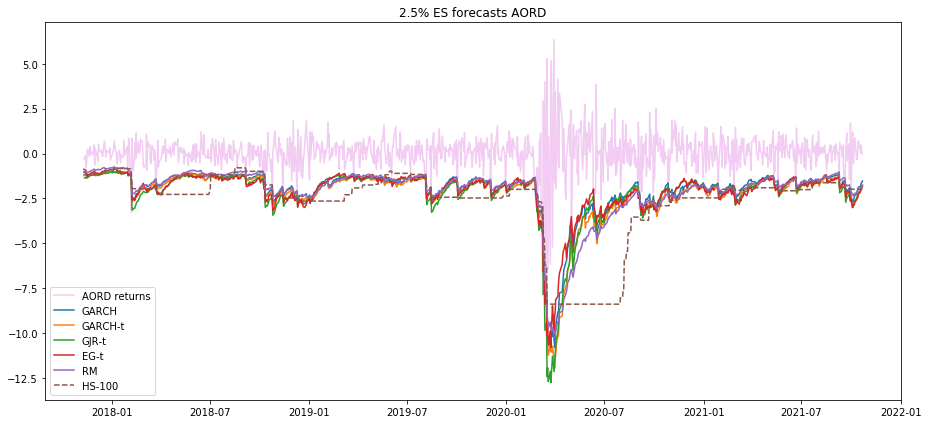

In [8]:
# Plot ES forecasts 2.5%
plt.figure(figsize=(13, 6))
plt.plot(r_ao[frst_fc:], 'm-', alpha=0.2, label='AORD returns')
plt.plot(es25_garch, '-', label='GARCH')
plt.plot(es25_garch_t, '-', label='GARCH-t')
plt.plot(es25_gjr_t, '-', label='GJR-t')
plt.plot(es25_egarch_t, '-', label='EG-t')
plt.plot(es25_rm, '-', label='RM')
plt.plot(es25_hs100, '--', label='HS-100')
plt.title('2.5% ES forecasts AORD')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# ES residuals and scaled ES residuals
xi25_garch, xis25_garch = es_resid(es25_garch, var25_garch, s_garch, r_ao[frst_fc:])
xi1_garch, xis1_garch = es_resid(es1_garch, var1_garch, s_garch, r_ao[frst_fc:])
xi25_garch_t, xis25_garch_t = es_resid(es25_garch_t, var25_garch_t, s_garch_t, r_ao[frst_fc:])
xi1_garch_t, xis1_garch_t = es_resid(es1_garch_t, var1_garch_t, s_garch_t, r_ao[frst_fc:])
xi25_gjr, xis25_gjr = es_resid(es25_gjr, var25_gjr, s_gjr, r_ao[frst_fc:])
xi1_gjr, xis1_gjr = es_resid(es1_gjr, var1_gjr, s_gjr, r_ao[frst_fc:])
xi25_gjr_t, xis25_gjr_t = es_resid(es25_gjr_t, var25_gjr_t, s_gjr_t, r_ao[frst_fc:])
xi1_gjr_t, xis1_gjr_t = es_resid(es1_gjr_t, var1_gjr_t, s_gjr_t, r_ao[frst_fc:])
xi25_egarch_t, xis25_egarch_t = es_resid(es25_egarch_t, var25_egarch_t, s_egarch_t, r_ao[frst_fc:])
xi1_egarch_t, xis1_egarch_t = es_resid(es1_egarch_t, var1_egarch_t, s_egarch_t, r_ao[frst_fc:])
xi25_hs100, xis25_hs100 = es_resid(es25_hs100, var25_hs100, s_hs100, r_ao[frst_fc:])
xi1_hs100, xis1_hs100 = es_resid(es1_hs100, var1_hs100, s_hs100, r_ao[frst_fc:])
xi25_rm, xis25_rm = es_resid(es25_rm, var25_rm, s_rm, r_ao[frst_fc:])
xi1_rm, xis1_rm = es_resid(es1_rm, var1_rm, s_rm, r_ao[frst_fc:])

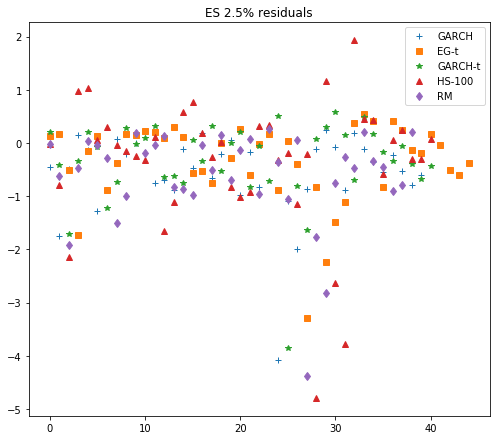

In [10]:
# Plot 2.5% ES residuals
plt.figure(figsize=(7, 6))
plt.plot(xi25_garch.values, '+', label='GARCH')
plt.plot(xi25_egarch_t.values, 's', label='EG-t')
plt.plot(xi25_garch_t.values, '*', label='GARCH-t')
plt.plot(xi25_hs100.values, '^', label='HS-100')
plt.plot(xi25_rm.values, 'd', label='RM')
plt.legend()
plt.tight_layout()
plt.title('ES 2.5% residuals')
plt.show()

### Answer guide
The HS-100 method seems likely the least accurate of these methods at 2.5% ES forecasting, based on its very different ES forecats that do not seem to "hug" the bottom "shoulder" of the data at all, as the other models do. Further, its ES residuals seem to be the most spread out, with many relatively extreme residuals, both positive and negative, in the ES residual plot.

On the other hand, the EG-t and GARCH-t seem potentially the most accurate, as they hug the bottom of the data in the time series plot, recover quickly after Covid in early 2020, and seem to have the fewest extreme ES residuals in the ES residual plot.

#### (c) Formally assess the accuracy of the 2.5% ES forecasts from the different models using the usual measures, i.e. mean residual, mean standardised residual with t-test, joint loss, RMSE and MAD statistics.

In [11]:
def check_es_fc_ex_10(es, var, s, r, p):
    hit = r < es
    n_hit = np.sum(hit)
    xi, xis = es_resid(es, var, s, r)
    rmse = np.sqrt(np.mean(xi ** 2))
    mad = np.mean(np.abs(xi))
    t_xi = ttest(xi, 0)[1]
    t_xis = ttest(xis, 0)[1]
    p_xis = ttest(xis, 0)[0]
    jl = jointloss(es, var, r, p)
    return [n_hit, np.mean(xi), t_xi, np.mean(xis), t_xis, p_xis, jl, rmse, mad]

In [12]:
# Table: 2.5% ES checks
tbl_es25_ex = pd.DataFrame({
    'G': check_es_fc_ex_10(es25_garch, var25_garch, s_garch, r_ao[frst_fc:], 0.025),
    'GJR': check_es_fc_ex_10(es25_gjr, var25_gjr, s_gjr, r_ao[frst_fc:], 0.025),
    'EG': check_es_fc_ex_10(es25_egarch, var25_egarch, s_egarch, r_ao[frst_fc:], 0.025),
    'RM': check_es_fc_ex_10(es25_rm, var25_rm, s_rm, r_ao[frst_fc:], 0.025),
    'G-t': check_es_fc_ex_10(es25_garch_t, var25_garch_t, s_garch_t, r_ao[frst_fc:], 0.025),
    'GJR-t': check_es_fc_ex_10(es25_gjr_t, var25_gjr_t, s_gjr_t, r_ao[frst_fc:], 0.025),
    'EG-t': check_es_fc_ex_10(es25_egarch_t, var25_egarch_t, s_egarch_t, r_ao[frst_fc:], 0.025),
    'HS-100': check_es_fc_ex_10(es25_hs100, var25_hs100, s_hs100, r_ao[frst_fc:], 0.025)
    },
    index=['Viol. (10?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es25_ex.round(4)

,G,GJR,EG,RM,G-t,GJR-t,EG-t,HS-100
Viol. (10?),31.0000,28.0000,28.0000,30.0000,26.0000,24.0000,25.0000,23.0000
Mean xi,-0.5448,-0.4134,-0.5249,-0.6186,-0.3425,-0.2730,-0.3327,-0.3579
t xi,-4.4214,-3.9934,-4.1284,-4.2726,-2.8128,-2.6790,-2.9873,-1.8447
Mean xi/s,-0.6044,-0.4564,-0.5310,-0.7479,-0.3838,-0.3175,-0.3194,-0.5383
t-stat,-5.2359,-4.5444,-4.6786,-5.0984,-3.1364,-3.0577,-2.8778,-2.2427
p-val,0.0000,0.0000,0.0000,0.0000,0.0032,0.0040,0.0062,0.0305
Joint loss,2.1475,2.0765,2.1012,2.2089,2.1107,2.0423,2.0698,2.3718
RMSE,0.9429,0.7812,0.9687,1.0860,0.8429,0.6925,0.8101,1.2783
MAD,0.6156,0.5065,0.6054,0.6864,0.5377,0.4541,0.5260,0.7986


### Answer guide
We generally expect the ES 2.5% level to fall close to the 1% quantile level. None of the models have achieved close to this ES violation rate, with all models having more than double that in fact. 

In terms of the ES residuals for each model, all models have ES residuals whose means are significantly different to 0 (all significantly negative, p-value $<0.05$)). All the models can be rejected and all give significantly biased ES 2.5% forecasts. 

In terms of joint loss, the GJR-t and EG-t are the most accurate joint 2.5% VaR and ES forecast models; HS-100 is the least accurate, as it also is regarding RMSE and MAD of the ES residuals. The GJR-t is the model with lowest RMSE and MAD of the ES residuals.   

#### Repeat parts (b) and (c) for the 1% ES forecasts 

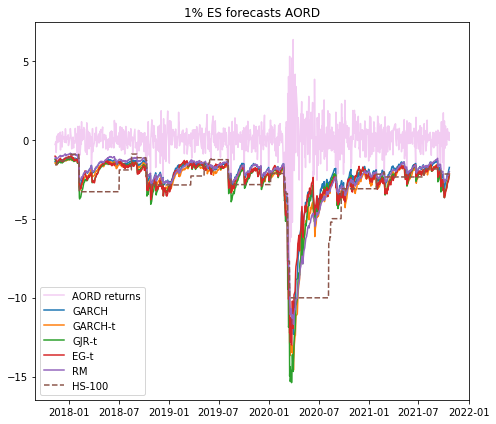

In [13]:
# Plot ES forecasts 1%
plt.figure(figsize=(7, 6))
plt.plot(r_ao[frst_fc:], 'm-', alpha=0.2, label='AORD returns')
plt.plot(es1_garch, '-', label='GARCH')
plt.plot(es1_garch_t, '-', label='GARCH-t')
plt.plot(es1_gjr_t, '-', label='GJR-t')
plt.plot(es1_egarch_t, '-', label='EG-t')
plt.plot(es1_rm, '-', label='RM')
plt.plot(es1_hs100, '--', label='HS-100')
plt.title('1% ES forecasts AORD')
plt.legend()
plt.tight_layout()
plt.show()

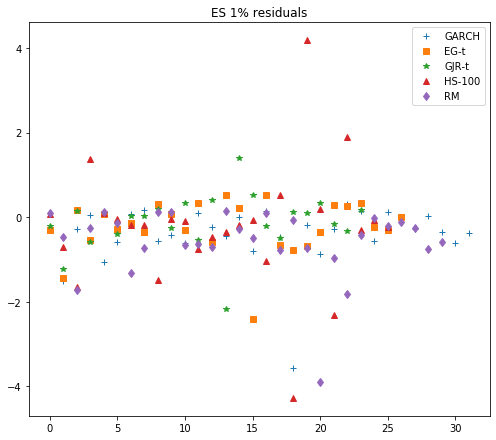

In [14]:
# Plot 1% ES residuals
plt.figure(figsize=(7, 6))
plt.plot(xi1_garch.values, '+', label='GARCH')
plt.plot(xi1_egarch_t.values, 's', label='EG-t')
plt.plot(xi1_gjr_t.values, '*', label='GJR-t')
plt.plot(xi1_hs100.values, '^', label='HS-100')
plt.plot(xi1_rm.values, 'd', label='RM')
plt.legend()
plt.tight_layout()
plt.title('ES 1% residuals')
plt.show()

### Answer guide
The HS-100 method aqgain seems likely the least accurate of these methods at 1% ES forecasting, based on its very different ES forecasts that do not seem to "hug" the bottom "shoulder" of the data at all, as the other models do. Further, its ES residuals again seem to be the most spread out, with many relatively extreme residuals, both positive and negative, in the ES residual plot.

On the other hand, the EG-t and GJR-t seem potentially the most accurate, as they hug the bottom of the data in the time series plot, recover quickly after Covid in early 2020, and seem to have the fewest extreme ES residuals in the ES residual plot.

In [15]:
# Table: 1% ES checks
tbl_es1_ex = pd.DataFrame({
    'G': check_es_fc_ex_10(es1_garch, var1_garch, s_garch, r_ao[frst_fc:], 0.01),
    'GJR': check_es_fc_ex_10(es1_gjr, var1_gjr, s_gjr, r_ao[frst_fc:], 0.01),
    'EG': check_es_fc_ex_10(es1_egarch, var1_egarch, s_egarch, r_ao[frst_fc:], 0.01),
    'RM': check_es_fc_ex_10(es1_rm, var1_rm, s_rm, r_ao[frst_fc:], 0.01),
    'G-t': check_es_fc_ex_10(es1_garch_t, var1_garch_t, s_garch_t, r_ao[frst_fc:], 0.01),
    'GJR-t': check_es_fc_ex_10(es1_gjr_t, var1_gjr_t, s_gjr_t, r_ao[frst_fc:], 0.01),
    'EG-t': check_es_fc_ex_10(es1_egarch_t, var1_egarch_t, s_egarch_t, r_ao[frst_fc:], 0.01),
    'HS-100': check_es_fc_ex_10(es1_hs100, var1_hs100, s_hs100, r_ao[frst_fc:], 0.01)
    },
    index=['Viol. (3?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es1_ex.round(4)

,G,GJR,EG,RM,G-t,GJR-t,EG-t,HS-100
Viol. (3?),22.0000,20.0000,23.0000,24.0000,16.0000,11.0000,15.0000,19.0000
Mean xi,-0.4189,-0.3362,-0.5342,-0.5816,-0.1508,-0.1148,-0.2324,-0.2382
t xi,-3.3871,-2.7808,-3.8643,-3.9320,-1.0427,-0.8528,-1.9167,-0.8328
Mean xi/s,-0.4825,-0.4215,-0.5620,-0.7068,-0.2327,-0.2031,-0.2656,-0.5038
t-stat,-4.0680,-3.9554,-4.6137,-4.5338,-1.7008,-1.7344,-2.1296,-1.5273
p-val,0.0003,0.0005,0.0001,0.0001,0.1009,0.0962,0.0428,0.1392
Joint loss,2.6180,2.4557,2.5455,2.7838,2.4325,2.2994,2.3895,2.8729
RMSE,0.8060,0.7228,0.8952,0.9863,0.7529,0.6558,0.6605,1.4499
MAD,0.4894,0.4697,0.5905,0.6264,0.4583,0.4351,0.4614,0.8779


### Answer guide
We generally expect the ES 1% level to fall close to the 0.3% - 0.4% quantile level. None of the models have achieved close to this ES violation rate, with all models having more than triple that rate in fact; even the best model (i.e. GJR-t) seems better suited to 1% VaR forecasts than 1% ES forecasts. 

In terms of the ES residuals for each model, most models have ES residuals whose means are significantly different to 0 (all significantly negative, p-value $<0.05$)). These models can be rejected: they give significantly biased ES 1% forecasts. 

Three models did not fail the ES residual test: GARCH-t, GJR-t and HS-100. 

In terms of joint loss, the GJR-t is easily the most accurate joint 1% VaR and ES forecast model; HS-100 is the least accurate, as it also is again regarding RMSE and MAD of the ES residuals. The GJR-t is again the model with lowest RMSE and MAD of the ES residuals. 

#### (e) Briefly discuss and compare the strengths and weaknesses of each of the models in forecasting ES 1-step-ahead for the AORD series. Rank the models on their forecasting performance, separately for 2.5% and 1% risk levels.

#### Answer guide
2.5% ES forecast model ranking:  1. GJR-t; 2. EG-t; 3. GJR-N; 4. GARCH-t; 5. GARCH-N; 6. EG-N; 7. RM; 8. HS-100

Reasoning: 1. GJR-t had the lowest joint loss, plus the lowest RMSE and MAD for ES residuals. It has the 2nd lowest ES violation rate, recovered very well after Covid in 2020 and the closest ES mean residual to 0. Strengths: ES residuals closest to 0 in mean, and lowest variation, ES forecasts follow the data very well and recover quickest after extreme returns; Weaknesses: ES residuals biased, too high ES violation rate.

2. EG-t had the 2nd lowest joint loss, plus the 3rd lowest RMSE and MAD for ES residuals. It had the 3rd lowest ES violation rate, recovered very well after Covid in 2020 and had the ES mean residual 2nd closest to 0. Strengths: ES residuals 2nd closest to 0 in mean, and 3rd lowest variation, ES forecasts follow the data very well and recover quickly after extreme returns; Weaknesses: ES residuals biased, too high ES violation rate.

3. GJR-N had the 3rd lowest joint loss, plus the 2nd lowest RMSE and MAD for ES residuals. It had the 5th lowest ES violation rate, recovered very well after Covid in 2020 and had the ES mean residual 5th closest to 0. Strengths: ES residuals had 2nd lowest variation, ES forecasts follow the data very well and recover quickly after extreme returns; Weaknesses: ES residuals biased and high ES violation rate, too high ES violation rate.

4. HS-100 had the highest joint loss and highest RMSE and MAD for ES residuals. It recovered the slowest and worst after Covd in 2020. However, it had the lowest ES violation rate, the ES mean residual 3rd closest to 0 and the highest p-value on the test (0.03). Strengths: ES forecasts closest to unbiased; Weaknesses: ES forecasts do not follow the data very well, take 100 days to recover after extreme returns or high volatility periods, and ES residuals are the most variable and also biased, too high ES violation rate.

5., 6., 7.  (all similar; ranked 5-7 in most categoies and metrics)

8. RM had the 2nd highest joint loss and 2nd highest RMSE and MAD for ES residuals. It recovered the 2nd slowest and 2nd worst after Covid in 2020. It had the 2nd highest ES violation rate and ES mean residual furthest awy from 0. It was worst or 2nd worst by all metrics here. Strengths: None; Weaknesses: ES forecasts do not follow the data very well, take longest of GARCH-type models to recover after extreme returns or high volatility periods, and ES residuals are the 2nd most variable and also biased, too high ES violation rate.

1% ES forecast model ranking:  1. GJR-t; 2. GARCH-t; 3. HS-100;  4. EG-t; 5. GJR-N; 6. EG-N; 7. GARCH-N; 8. RM

Reasoning: 1. GJR-t had the lowest joint loss, plus the lowest RMSE and MAD for ES residuals. It has the 2nd lowest ES violation rate, recovered very well after Covid in 2020 and was not rejected by the ES mean test, further having the ES mean residual closest to 0. Strengths: ES residuals unbiased and closest to 0 in mean, with lowest variation, ES forecasts follow the data very well and recover quickest after extreme returns; Weaknesses: Still too high ES violation rate.

2. GARCH-t also did not get rejected by the ES mean test, further having the ES mean residual 2nd closest to 0. It had the 3rd lowest joint loss, plus the 4th lowest RMSE and 2nd lowest MAD for ES residuals. It had the 3rd lowest ES violation rate and recovered pretty well after Covid in 2020. Strengths: ES residuals unbiased and 2nd closest to 0 in mean, with 2nd and 4th lowest variation (RMSE and MAD), ES forecasts follow the data well and recover quickly after extreme returns; Weaknesses: Still too high ES violation rate, recover more slowly than GJR and EGARCH models after extreme returns.

3. HS-100 also did not get rejected by the ES mean test, further having the ES mean residual 4th closest to 0 and the 4th lowest ES violation rate. However, it had the highest joint loss and highest RMSE and MAD for ES residuals. It recovered the slowest and worst after Covid in 2020. But it was the 3rd best model to not be rejected. Strengths: ES forecast unbiased; Weaknesses: ES forecasts do not follow the data very well, take 100 days to recover after extreme returns or high volatility periods, and ES residuals are the most variable, too high ES violation rate.

4. EG-t was rejected by the ES mean test. However, it had the 2nd lowest joint loss, plus the 2nd lowest RMSE and 3rd lowest MAD for ES residuals. It had the 2nd lowest ES violation rate, recovered very well after Covid in 2020 and had the ES mean residual 2nd closest to 0. Strengths: ES residuals 2nd closest to 0 in mean (though still biased), with 2nd and 3rd lowest variation (RMSE and MAD), ES forecasts follow the data well and recover quickest (with GJR) after extreme returns; Weaknesses: ES forecasts biased, with still too high ES violation rate.

5. GJR-N was rejected by the ES mean test. However, it had the 4th lowest joint loss, plus the 3rd lowest RMSE and 4th lowest MAD for ES residuals. It had the 5th lowest ES violation rate, recovered very well after Covid in 2020 and had the ES mean residual 5th closest to 0. Strengths: ES residuals 3rd and 4th lowest variation (RMSE and MAD), ES forecasts follow the data well and recover quickly after extreme returns; Weaknesses: ES forecasts biased, with still too high ES violation rate.

6., 7.  (all similar; ranked 6-7 in most categoies and metrics)

8. RM had the 2nd highest joint loss and 2nd highest RMSE and MAD for ES residuals. It recovered the 2nd slowest and 2nd worst after Covid in 2020. It had the highest ES violation rate and ES mean residual furthest away from 0. It was worst or 2nd worst by all metrics here. Strengths: None; Weaknesses: ES forecasts do not follow the data very well, take longest of GARCH-type models to recover after extreme returns or high volatility periods, and ES residuals are the 2nd most variable and also biased, too high ES violation rate.


## Q2
Now we will use the SP500 lagged return as an exogenous regressor in the GJR-t model to see if this improves performance in any way.

In [16]:
name_us = 'us_yf_2009_2021.csv'
if not os.path.isfile(name_us):
    data_us = yf.download("^GSPC", start='2009-01-01', end='2021-10-23')
    data_us.to_csv(name_us)

data_us = pd.read_csv(name_us, index_col='Date', parse_dates=True, dayfirst=True)
r_us = 100 * np.log(data_us['Adj Close']).diff().dropna()
r_us

Date
2009-01-02    3.111882
2009-01-05   -0.467929
2009-01-06    0.778674
2009-01-07   -3.046912
2009-01-08    0.339132
                ...   
2021-10-15    0.743252
2021-10-18    0.336909
2021-10-19    0.736614
2021-10-20    0.365733
2021-10-21    0.299139
Name: Adj Close, Length: 3224, dtype: float64

In [17]:
# Synchronise by date
date_common = data_us.index.intersection(data_ao.index)
p_us = data_us.loc[date_common, 'Adj Close']
p_ao = data_ao.loc[date_common, 'Adj Close']
r_us = 100 * np.log(p_us).diff().dropna()
r_ao = 100 * np.log(p_ao).diff().dropna()
r_ao

Date
2009-01-05   -0.460617
2009-01-06    1.372821
2009-01-07    1.051591
2009-01-08   -2.295330
2009-01-09    1.004918
                ...   
2021-10-15    0.706144
2021-10-18    0.201772
2021-10-19    0.006502
2021-10-20    0.479978
2021-10-21    0.016820
Name: Adj Close, Length: 3156, dtype: float64

In [18]:
# Last day of in-sample period
last_in = '2017-10-05'
# First day of forecasting period
frst_fc = '2017-10-06'

len(r_ao['2017-10-06':]), len(r_us['2017-10-06':])

# Leave out last 1000 days for forecasting

(1000, 1000)

#### (a) Fit the Reg-GJR-GARCH(1,1)-t model to the AORD returns in the in-sample period, using the SP500 returns as a lag-1 regressor variable. Write down and interpret the estimated model


In [19]:
reg_gjgarcht_ao = arch_model(r_ao[:'2017-10-05'][1:], mean='ARX', lags=0, 
                             x = r_us[:'2017-10-04'], vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

reg_gjgarcht_ao_fit = reg_gjgarcht_ao.fit( disp= 'off' )
print(reg_gjgarcht_ao_fit.summary())

                           AR-X - GJR-GARCH Model Results                           
Dep. Variable:                    Adj Close   R-squared:                       0.281
Mean Model:                            AR-X   Adj. R-squared:                  0.281
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2379.70
Distribution:      Standardized Student's t   AIC:                           4773.40
Method:                  Maximum Likelihood   BIC:                           4813.13
                                              No. Observations:                 2155
Date:                      Fri, Nov 12 2021   Df Residuals:                     2153
Time:                              10:57:19   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

In [20]:
n = 2155

y = r_ao[1: n + 1]
x = r_us[0: n]

In [21]:
reg_gjgarcht_ao = arch_model(y, mean='ARX', lags=0, 
                             x = x, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

reg_gjgarcht_ao_fit = reg_gjgarcht_ao.fit( disp= 'off' )
print(reg_gjgarcht_ao_fit.summary())

                           AR-X - GJR-GARCH Model Results                           
Dep. Variable:                    Adj Close   R-squared:                       0.281
Mean Model:                            AR-X   Adj. R-squared:                  0.281
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2379.70
Distribution:      Standardized Student's t   AIC:                           4773.40
Method:                  Maximum Likelihood   BIC:                           4813.13
                                              No. Observations:                 2155
Date:                      Fri, Nov 12 2021   Df Residuals:                     2153
Time:                              10:57:19   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

In [22]:
r_ao[:'2017-10-05'][1:]

Date
2009-01-06    1.372821
2009-01-07    1.051591
2009-01-08   -2.295330
2009-01-09    1.004918
2009-01-12   -1.544303
                ...   
2017-09-29    0.233521
2017-10-02    0.804427
2017-10-03   -0.469035
2017-10-04   -0.776752
2017-10-05    0.012233
Name: Adj Close, Length: 2155, dtype: float64

In [23]:
r_us[:'2017-10-04']

Date
2009-01-05   -0.467929
2009-01-06    0.778674
2009-01-07   -3.046912
2009-01-08    0.339132
2009-01-09   -2.153321
                ...   
2017-09-28    0.120389
2017-09-29    0.369826
2017-10-02    0.386652
2017-10-03    0.215651
2017-10-04    0.124594
Name: Adj Close, Length: 2155, dtype: float64

### Answer guide
The estimated model is:

$r_t = -0.011 + 0.509 SP500_{t-1} + a_t$,   where $a_t = \sigma_t \varepsilon_t$ and where

$$
\sigma_t^2 = 0.018 + (0.030 + 0.129 I_{t-1}) a_{t-1}^2 + 0.877 \sigma_{t-1}^2
$$

where $\varepsilon_t \sim t^*_{14.5} (0,1)$ is a Student-t distribution standardised to have variance 1. 

The model says that the AORD index percentage log-return on day t can be estimated by -0.011 plus 50.9% of yesterdays US SP500 index percentage log-return; i.e. if the SP500 goes up by 1% yesterday, the AORD is predicted to go up by 0.5% today. 

The variance of the AORD index percentage log-return on day t can be estimated by 0.018 plus, on days when yesterday's return shock is positive, 0.030 times yesterday's return shock squared, or on days when yesterday's return shock is negative, 0.159 times yesterday's return shock squared, plus 0.877 times yesterday's estimated variance.   

#### (b) Calculate 2.5% and 1% ES forecasts for each day of the forecast period, for the models Reg-GJR-t, GJR-t and HS-100. Plot the forecasts and the ES residuals for each.

In [24]:
var25_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
var1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es25_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
es1_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# Volatility
s_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
s_hs100 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# Estimated DF for models with t errors
df_gjr_t2 = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')
df_reg_gjr_t = pd.Series(index=r_ao[frst_fc:].index, dtype='float64')

# Instantiate the GARCH-type model objects

y = r_ao[1:]
x = r_us[:-1]
gjr_t = arch_model(y, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')


n_fore = len(r_ao[frst_fc:])
n_wind = len(y) -  n_fore
for i in tqdm(range(n_fore)):
    y_is = y[i: i+n_wind]
    x_is = x[i: i+n_wind]
    gjr_t = arch_model(y_is, mean='Constant', vol='GARCH', p=1, q=1, o=1, dist='StudentsT')
    reg_gjr_t = arch_model(y_is, mean='ARX', lags=0, x = x_is, vol='GARCH', p=1, q=1, o=1, dist='StudentsT')

    if i % 20 == 0:
            gjr_t_fit = gjr_t.fit( disp = "off" )
            reg_gjr_t_fit = reg_gjr_t.fit( disp = "off" )
       
    # ARX-GJR-GARCH-t
    xnew = x[i+n_wind:i+n_wind+1]
    
    
    fc = reg_gjr_t_fit.forecast(horizon=1, reindex=False, x=xnew)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, reg_gjr_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, reg_gjr_t_fit.params['nu'])
    var25_reg_gjr_t[i] = temp25.values  #loc[var25_reg_gjr_t.index[i]]
    var1_reg_gjr_t[i] = temp1.values    #.loc[var1_reg_gjr_t.index[i]]
      
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, reg_gjr_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, reg_gjr_t_fit.params['nu'])
    es25_reg_gjr_t[i] = es25.values #.loc[es25_reg_gjr_t.index[i]]
    es1_reg_gjr_t[i] = es1.values #.loc[es1_reg_gjr_t.index[i]]
    s_reg_gjr_t[i] = s.values  #.loc[s_reg_gjr_t.index[i]]
    df_reg_gjr_t[i] = reg_gjr_t_fit.params['nu']
    if var25_reg_gjr_t[i] > 0:
        var25_reg_gjr_t[i] = var25_reg_gjr_t[i-1]
        es25_reg_gjr_t[i] = es25_reg_gjr_t[i-1]
        var1_reg_gjr_t[i] = var1_reg_gjr_t[i-1]
        es1_reg_gjr_t[i] = es1_reg_gjr_t[i-1]
        s_reg_gjr_t[i] = s_reg_gjr_t[i-1]
        
    
    
    
    # GJR-GARCH-t
    fc = gjr_t_fit.forecast(horizon=1, reindex=False)
    temp25 = fc.mean + np.sqrt(fc.variance) * qt(0.025, gjr_t_fit.params['nu'])
    temp1 = fc.mean + np.sqrt(fc.variance) * qt(0.01, gjr_t_fit.params['nu'])
    var25_gjr_t2[i] = temp25.values #.loc[var25_gjr_t2.index[i]]
    var1_gjr_t2[i] = temp1.values #.loc[var1_gjr_t2.index[i]]
    s = np.sqrt(fc.variance)
    es25 = fc.mean + s * est(0.025, gjr_t_fit.params['nu'])
    es1 = fc.mean + s * est(0.01, gjr_t_fit.params['nu'])
    es25_gjr_t2[i] = es25.values #.loc[es25_gjr_t2.index[i]]
    es1_gjr_t2[i] = es1.values #.loc[es1_gjr_t2.index[i]]
    s_gjr_t2[i] = s.values #.loc[s_gjr_t2.index[i]]
    df_gjr_t2[i] = gjr_t_fit.params['nu'] 
    
    # HS-100
    var25_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.025)
    var1_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].quantile(0.01)
    es25_hs100[i] = es(r_ao[(i + n_wind - 100):(i + n_wind)], 0.025)
    es1_hs100[i] = es(r_ao[(i + n_wind - 100):(i + n_wind)], 0.01)
    s_hs100[i] = r_ao[(i + n_wind - 100):(i + n_wind)].std()

  0%|          | 0/1000 [00:00<?, ?it/s]

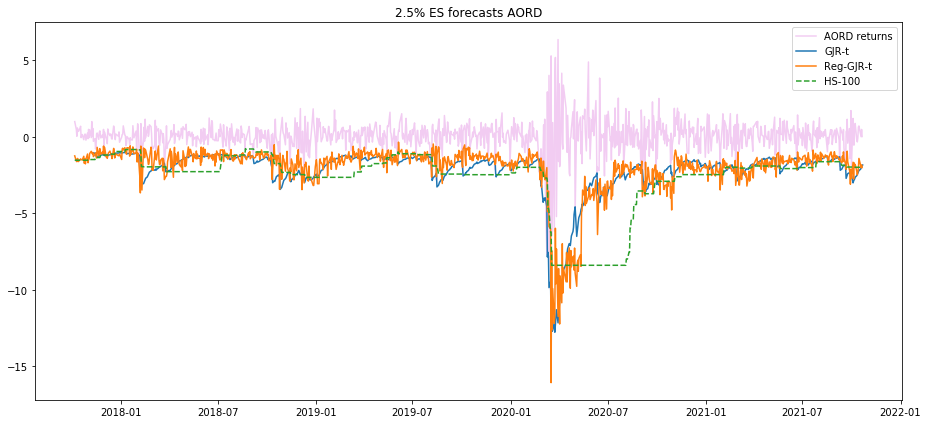

In [44]:
# Plot ES forecasts 2.5%
plt.figure(figsize=(13, 6))
plt.plot(r_ao[frst_fc:], 'm-', alpha=0.2, label='AORD returns')
plt.plot(es25_gjr_t, '-', label='GJR-t')
plt.plot(es25_reg_gjr_t, '-', label='Reg-GJR-t')
plt.plot(es25_hs100, '--', label='HS-100')
plt.title('2.5% ES forecasts AORD')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# ES residuals and scaled ES residuals
xi25_gjr_t, xis25_gjr_t = es_resid(es25_gjr_t2, var25_gjr_t2, s_gjr_t2, r_ao[frst_fc:])
xi1_gjr_t, xis1_gjr_t = es_resid(es1_gjr_t2, var1_gjr_t2, s_gjr_t2, r_ao[frst_fc:])
xi25_reg_gjr_t, xis25_reg_gjr_t = es_resid(es25_reg_gjr_t, var25_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:])
xi1_reg_gjr_t, xis1_reg_gjr_t = es_resid(es1_reg_gjr_t, var1_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:])
xi25_hs100, xis25_hs100 = es_resid(es25_hs100, var25_hs100, s_hs100, r_ao[frst_fc:])
xi1_hs100, xis1_hs100 = es_resid(es1_hs100, var1_hs100, s_hs100, r_ao[frst_fc:])

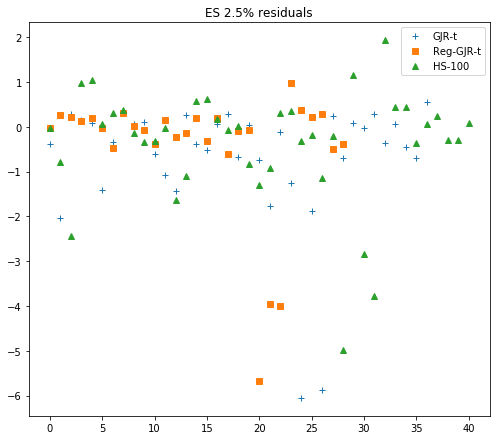

In [27]:
# Plot 2.5% ES residuals
plt.figure(figsize=(7, 6))
plt.plot(xi25_gjr_t.values, '+', label='GJR-t')
plt.plot(xi25_reg_gjr_t.values, 's', label='Reg-GJR-t')
plt.plot(xi25_hs100.values, '^', label='HS-100')
plt.legend()
plt.tight_layout()
plt.title('ES 2.5% residuals')
plt.show()

### Answer guide
The Reg-GJR-t model, using SP500 returns as a mean equation regressor, gives 2.5% ES forecasts that seem more variable than those from other GARCH models. This is due to the effect of the regressor: i.e. the AORD mean gets 50% of the daily returns on SP500; thus the mean AORD return is quite changeable from day to day. NOte that the volatility persistence here is 0.877 + 0.5 0.159 + 0.03 \approx 0.98$, which is still very high. Thus, low persistence does not explain the higher day-day variation in this model's ES forecasts, compared to usual GARCH models. The model's ES forecasts mostly follow the pattern of the GJR-t model's closely, but with more day-day variation.

The ES residuals for the Reg-GJR-t model seems slightly less variable than those for the GJR-t and HS100 models.

#### (c) Formally assess the accuracy of the 2.5% ES forecasts from the different models using the usual measures, i.e. mean residual, mean standardised residual with t-test, joint loss, RMSE and MAD statistics.

In [28]:
# Table: 2.5% ES checks
tbl_es25_ex = pd.DataFrame({
    'GJR-t': check_es_fc_ex_10(es25_gjr_t2, var25_gjr_t2, s_gjr_t2, r_ao[frst_fc:], 0.025),
    'Reg-GJR-t': check_es_fc_ex_10(es25_reg_gjr_t, var25_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:], 0.025),
    'HS-100': check_es_fc_ex_10(es25_hs100, var25_hs100, s_hs100, r_ao[frst_fc:], 0.025)
    },
    index=['Viol. (10?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es25_ex.round(4)

,GJR-t,Reg-GJR-t,HS-100
Viol. (10?),22.0000,16.0000,23.0000
Mean xi,-0.6994,-0.4622,-0.3707
t xi,-2.9524,-1.6947,-1.8468
Mean xi/s,-1.1348,-0.7772,-0.5744
t-stat,-3.1117,-1.6152,-2.1869
p-val,0.0036,0.1175,0.0347
Joint loss,2.4990,1.8389,2.4360
RMSE,1.5841,1.5155,1.3225
MAD,0.8561,0.7043,0.8172


### Answer guide
The Reg-GJR-t model is easily closest to the expected 1% violation rate for 2.5% ES forecasts. It is the only model not giving significantly biased ES 2.5% forecasts too. It has lowest joint 2.5% VaR, ES forecast loss and lowest ES residual MAD, 2nd lowest RMSE. It is clearly the optimal ES 2.5% forecasting model of these 3 models. 

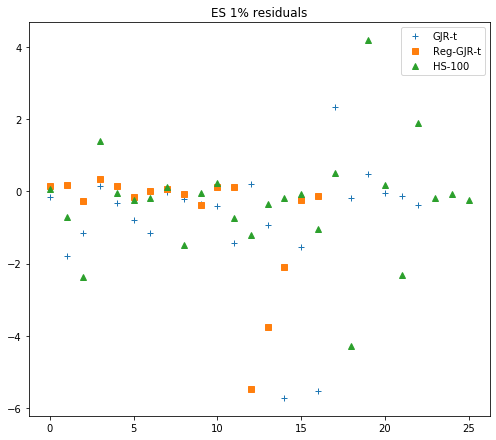

In [29]:
# Plot 1% ES residuals
plt.figure(figsize=(7, 6))
plt.plot(xi1_gjr_t.values, '+', label='GJR-t')
plt.plot(xi1_reg_gjr_t.values, 's', label='Reg-GJR-t')
plt.plot(xi1_hs100.values, '^', label='HS-100')
plt.legend()
plt.tight_layout()
plt.title('ES 1% residuals')
plt.show()

In [30]:
# Table: 1% ES checks
tbl_es1_ex = pd.DataFrame({
    'GJR-t': check_es_fc_ex_10(es1_gjr_t2, var1_gjr_t2, s_gjr_t2, r_ao[frst_fc:], 0.01),
    'Reg-GJR-t': check_es_fc_ex_10(es1_reg_gjr_t, var1_reg_gjr_t, s_reg_gjr_t, r_ao[frst_fc:], 0.01),
    'HS-100': check_es_fc_ex_10(es1_hs100, var1_hs100, s_hs100, r_ao[frst_fc:], 0.01)
    },
    index=['Viol. (3?)', 'Mean xi', 't xi', 'Mean xi/s', 't-stat', 'p-val', 'Joint loss', 'RMSE', 'MAD']
)
tbl_es1_ex.round(4)

,GJR-t,Reg-GJR-t,HS-100
Viol. (3?),19.0000,10.0000,18.0000
Mean xi,-0.8299,-0.6689,-0.2773
t xi,-2.3031,-1.7209,-0.9379
Mean xi/s,-1.4768,-1.1483,-0.6142
t-stat,-2.8733,-1.4917,-1.6162
p-val,0.0088,0.1552,0.1186
Joint loss,3.2675,2.2302,3.0303
RMSE,1.8829,1.6925,1.5038
MAD,1.1050,0.8042,0.9359


### Answer guide
The Reg-GJR-t model, has ES residuals that again seem slightly less variable than those for the GJR-t and HS100 models.

The Reg-GJR-t model is easily closest to the expected 0.3-0.4% violation rate for 1% ES forecasts (though it still seems better as a 1% VaR forecast). The Reg-GJR-t and HS100 are the only models not giving significantly biased ES 1% forecasts. The Reg-GJR-t has lowest joint 1% VaR, ES forecast loss and lowest ES residual MAD, 2nd lowest RMSE (1st is HS100). The Reg-GJR-t is clearly the optimal ES 1% forecasting model of these 3 models. 

#### (d) Assess the accuracy of the 2.5% and 1% VaR forecasts from these models. Compare the results to those obtained in Lab Tutorial 12 

In [31]:
# 2.5% VaR forecast accuracy checks
tbl_var25 = pd.DataFrame({
    'GJR-t': check_var_fc(var25_gjr_t2, r_ao[frst_fc:], 0.025),
    'Reg-GJR-t': check_var_fc(var25_reg_gjr_t, r_ao[frst_fc:], 0.025),
    'HS100': check_var_fc(var25_hs100, r_ao[frst_fc:], 0.025)
    },
    index=['Viol. (25)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var25.round(4)

,GJR-t,Reg-GJR-t,HS100
Viol. (25),37.0000,29.0000,41.0000
$\hat{p}$,0.0370,0.0290,0.0410
$\hat{p}/p$,1.4800,1.1600,1.6400
UC,0.0151,0.4178,0.0012
Ind,0.0000,0.0086,0.0010
DQ,0.0000,0.0000,0.0000
Loss,86.1931,65.9072,94.6055


### Answer guide
The quantile loss function clearly and strongly favours the Reg-GJR-t model in forecasting 2.5% VaR, over the other two models. 
It is the only model with close to the expected VRate of 2.5%, with 2.9%, and is the only model not rejected for a VRate significantly different to 0.025. However, the Reg-GJR-t model fails the Ind and DQ tests (as do all models here), meaning its violations are correlated or clustered. The 2.5% violations plot below indicates some potential clustering in late 2018 and early 2020 as volatility rose and peaked, for the Reg-GJR-t model.

In [32]:
# 1% VaR forecast accuracy checks
tbl_var1 = pd.DataFrame({
    'GJR-t': check_var_fc(var1_gjr_t2, r_ao[frst_fc:], 0.01),
    'Reg-GJR-t': check_var_fc(var1_reg_gjr_t, r_ao[frst_fc:], 0.01),
    'HS100': check_var_fc(var1_hs100, r_ao[frst_fc:], 0.01)
    },
    index=['Viol. (10)', '$\hat{p}$', '$\hat{p}/p$', 'UC', 'Ind', 'DQ', 'Loss']
)
tbl_var1.round(4)

,GJR-t,Reg-GJR-t,HS100
Viol. (10),23.0000,17.0000,26.000
$\hat{p}$,0.0230,0.0170,0.026
$\hat{p}/p$,2.3000,1.7000,2.600
UC,0.0000,0.0261,0.000
Ind,0.0013,0.2897,0.000
DQ,0.0000,0.0000,0.000
Loss,51.8908,37.5837,51.479


### Answer guide
The quantile loss function also clearly and strongly favours the Reg-GJR-t model in forecasting 1% VaR, over the other two models. It is the model with closest to the expected VRate of 1%, with 1.7%, however all models are rejected for a VRate significantly different to 0.01. Whilst the Reg-GJR-t model does not fail the Ind test, it is rejected by the DQ test (as are all models), meaning its violations are again correlated or clustered. The 1% violations plot below indicates some potential clustering in early 2020 as volatility rose and peaked, for the Reg-GJR-t model.

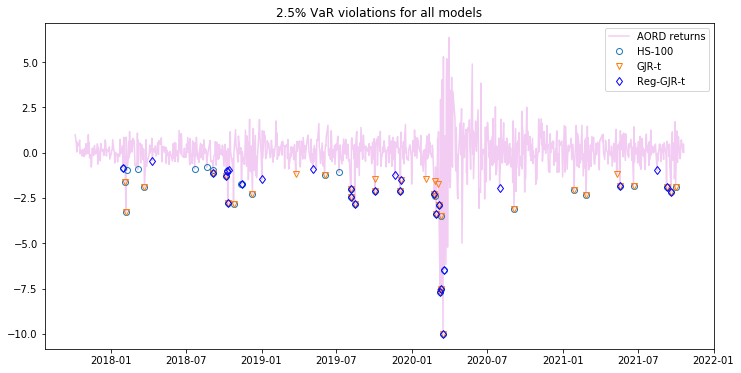

In [33]:
# Violations (hits)
hit25_gjr_t2 = r_ao[frst_fc:] < var25_gjr_t2
hit1_gjr_t2 = r_ao[frst_fc:] < var1_gjr_t2
hit25_reg_gjr_t = r_ao[frst_fc:] < var25_reg_gjr_t
hit1_reg_gjr_t = r_ao[frst_fc:] < var1_reg_gjr_t
hit25_hs100 = r_ao[frst_fc:] < var25_hs100
hit1_hs100 = r_ao[frst_fc:] < var1_hs100

# 2.5% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit25_hs100], 'o', mfc='none', label='HS-100')
plt.plot(r_ao[frst_fc:][hit25_gjr_t2], 'v', mfc='none', label='GJR-t')
plt.plot(r_ao[frst_fc:][hit25_reg_gjr_t], 'db', mfc='none', label='Reg-GJR-t')
plt.title('2.5% VaR violations for all models')
plt.legend()
plt.show()

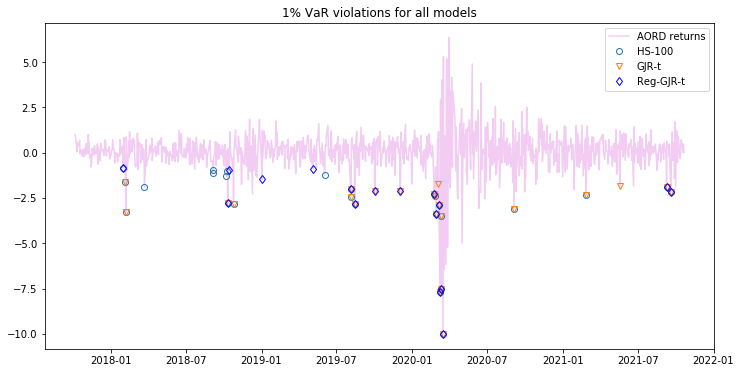

In [34]:
# 1% VaR violations
plt.figure(figsize=(12, 6))
plt.plot(r_ao[frst_fc:], '-m', alpha=0.2, label='AORD returns')
plt.plot(r_ao[frst_fc:][hit1_hs100], 'o', mfc='none', label='HS-100')
plt.plot(r_ao[frst_fc:][hit1_gjr_t2], 'v', mfc='none', label='GJR-t')
plt.plot(r_ao[frst_fc:][hit1_reg_gjr_t], 'db', mfc='none', label='Reg-GJR-t')
plt.title('1% VaR violations for all models')
plt.legend()
plt.show()